# ***1. Import Necessary Libraries***


In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import tensorflow as tf
import keras
import cv2
import random
import shutil

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNet

# ***2. FER2013 and AffectNet downloaded from Kaggle and extracted ***

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013
!kaggle datasets download -d noamsegal/affectnet-training-data

#Extract FER
with zipfile.ZipFile('fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')

# Check the extracted files
for root, dirs, files in os.walk('fer2013'):
    for file in files:
        print(os.path.join(root, file))


# Extract AffectNet
with zipfile.ZipFile('affectnet-training-data.zip', 'r') as zip_ref:
    zip_ref.extractall('affectnet')


for root, dirs, files in os.walk('affectnet'):
    for file in files:
        print(os.path.join(root, file))



Görüntülenen çıkış son 5000 satıra kısaltıldı.
affectnet/contempt/image0041957.jpg
affectnet/contempt/image0036726.jpg
affectnet/contempt/image0003929.jpg
affectnet/contempt/image0033006.jpg
affectnet/contempt/image0033032.jpg
affectnet/contempt/image0041421.jpg
affectnet/contempt/image0022580.jpg
affectnet/contempt/image0038646.jpg
affectnet/contempt/image0032265.jpg
affectnet/contempt/image0014993.jpg
affectnet/contempt/image0033680.jpg
affectnet/contempt/image0029944.jpg
affectnet/contempt/image0042088.jpg
affectnet/contempt/image0038078.jpg
affectnet/contempt/image0031139.jpg
affectnet/contempt/image0032679.jpg
affectnet/contempt/image0038630.jpg
affectnet/contempt/image0041767.jpg
affectnet/contempt/image0042359.jpg
affectnet/contempt/image0042529.jpg
affectnet/contempt/image0038072.jpg
affectnet/contempt/image0040348.jpg
affectnet/contempt/image0025031.jpg
affectnet/contempt/image0033663.jpg
affectnet/contempt/image0032485.jpg
affectnet/contempt/image0035120.jpg
affectnet/contemp

# ***3. AffectNet Preprocessing***

In order to make AffectNet similar to FER2013, some operations was made.

*  Contempt, disgust and surprised emotions are not included. Anger, fear, happy, neutral and sad are kept.
*   Images resized 48x48 pixels from 96x96 pixels.

*   Converted grayscale from RGB.

*   Splitted test and train folders with a ratio of 0.8.

*  Shuffled to create a random distrubition.




In [ ]:
# Define the emotions to keep and their mappings
affectnet_emotions_to_keep = ['anger', 'fear', 'happy', 'neutral', 'sad']
emotion_mapping = {
    'anger': 'angry',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad'
}

# Preprocess AffectNet (resize, convert grayscale, split, shuffle)
def preprocess_affectnet_images(src_dir, train_dir, test_dir, target_size=(48, 48), split_ratio=0.8):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for emotion in affectnet_emotions_to_keep:
        class_dir = os.path.join(src_dir, emotion)
        train_class_dir = os.path.join(train_dir, emotion_mapping[emotion])
        test_class_dir = os.path.join(test_dir, emotion_mapping[emotion])

        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)

        files = os.listdir(class_dir)
        random.shuffle(files)
        split_point = int(len(files) * split_ratio)

        for img_name in tqdm(files[:split_point], desc=f'Processing {emotion} - Train'):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, target_size)
            cv2.imwrite(os.path.join(train_class_dir, img_name), resized_img)

        for img_name in tqdm(files[split_point:], desc=f'Processing {emotion} - Test'):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, target_size)
            cv2.imwrite(os.path.join(test_class_dir, img_name), resized_img)

# Paths
affectnet_src_dir = "affectnet/"
affectnet_train_preprocessed_dir = "affectnet_preprocessed/train/"
affectnet_test_preprocessed_dir = "affectnet_preprocessed/test/"

# Preprocess AffectNet images
preprocess_affectnet_images(affectnet_src_dir, affectnet_train_preprocessed_dir, affectnet_test_preprocessed_dir)

# ***4. Checked the number of data in each dataset***

In [ ]:
fer_train = 'fer2013/train/'
fer_test = 'fer2013/test/'

affect_train = 'affectnet_preprocessed/train/'
affect_test = 'affectnet_preprocessed/test/'

# Function to check if anything is missing
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

In [ ]:
fer_tr_count = Classes_Count(fer_train, 'Train').transpose().sort_values(by="Train", ascending=False)
fer_ts_count = Classes_Count(fer_test, 'Test').transpose().sort_values(by="Test", ascending=False)

affect_tr_count = Classes_Count(affect_train, 'Train').transpose().sort_values(by="Train", ascending=False)
affect_ts_count = Classes_Count(affect_test, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([fer_tr_count,fer_ts_count] , axis=1)

Train  Test
happy      7215  1774
neutral    4965  1233
sad        4830  1247
fear       4097  1024
angry      3995   958
surprise   3171   831
disgust     436   111

In [ ]:
pd.concat([affect_tr_count,affect_ts_count], axis=1)

Train  Test
neutral   4100  1026
happy     4035  1009
angry     2574   644
fear      2540   636
sad       2472   619

# ***5. FER2013 and preprocessed AffectNet combined to same folder***

In [ ]:
# Function to combine FER and AffectNet
def combine_datasets(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for src_dir in src_dirs:
        for emotion in os.listdir(src_dir):
            src_emotion_dir = os.path.join(src_dir, emotion)
            dest_emotion_dir = os.path.join(dest_dir, emotion)

            if not os.path.exists(dest_emotion_dir):
                os.makedirs(dest_emotion_dir)

            for img_name in tqdm(os.listdir(src_emotion_dir), desc=f'Copying {emotion} from {src_dir}'):
                src_img_path = os.path.join(src_emotion_dir, img_name)
                dest_img_path = os.path.join(dest_emotion_dir, img_name)
                shutil.copy(src_img_path, dest_img_path)

# Combined dataset paths
train_dir = 'dataset/train/'
test_dir = 'dataset/test'

combine_datasets([fer_train, affect_train], train_dir)

combine_datasets([fer_test, affect_test], test_dir)


Copying happy from affectnet_preprocessed/train/: 100%|██████████| 4035/4035 [00:00<00:00, 11553.34it/s]
Copying neutral from affectnet_preprocessed/train/: 100%|██████████| 4100/4100 [00:00<00:00, 11429.66it/s]
Copying happy from affectnet_preprocessed/test/: 100%|██████████| 1009/1009 [00:00<00:00, 11737.51it/s]
Copying neutral from affectnet_preprocessed/test/: 100%|██████████| 1026/1026 [00:00<00:00, 11742.05it/s]
Copying fear from affectnet_preprocessed/test/: 100%|██████████| 636/636 [00:00<00:00, 11273.44it/s]


# ***6. Remove Disgust and Surprised from combined dataset***

FER'deki disgust ve surprised'ı silip datasetleri öyle birleştirecektim ama unutmuşum o yüzden böyle yaptım.

In [ ]:
# Remove disgust and surprise emotions

def remove_unwanted_emotions(dataset_dir, emotions_to_remove):
    for emotion in emotions_to_remove:
        emotion_dir = os.path.join(dataset_dir, emotion)
        if os.path.exists(emotion_dir):
            shutil.rmtree(emotion_dir)
            print(f'Removed {emotion_dir}')


emotions_to_remove = ['disgust', 'surprise']

remove_unwanted_emotions(train_dir, emotions_to_remove)
remove_unwanted_emotions(test_dir, emotions_to_remove)


Removed dataset/train/disgust
Removed dataset/train/surprise
Removed dataset/test/disgust
Removed dataset/test/surprise


# ***7. Visualizing Images***

Random 5 images in each class are visualized for check purposes.

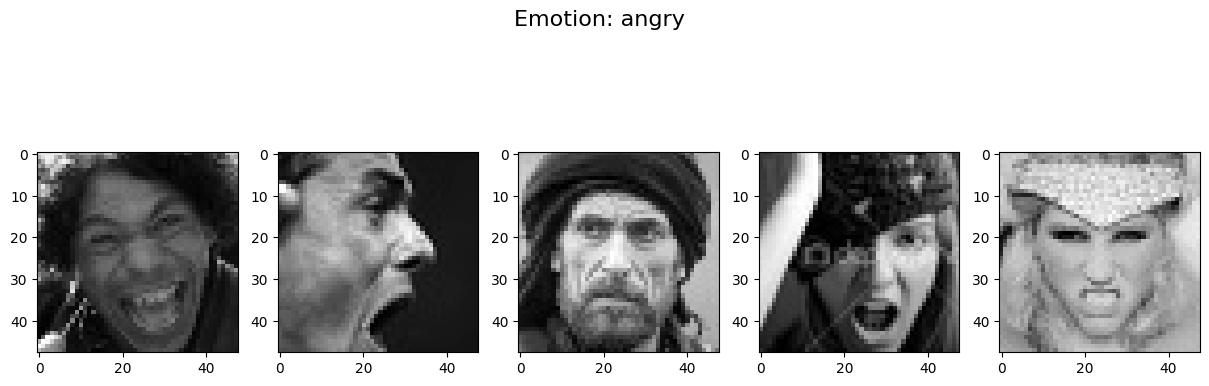

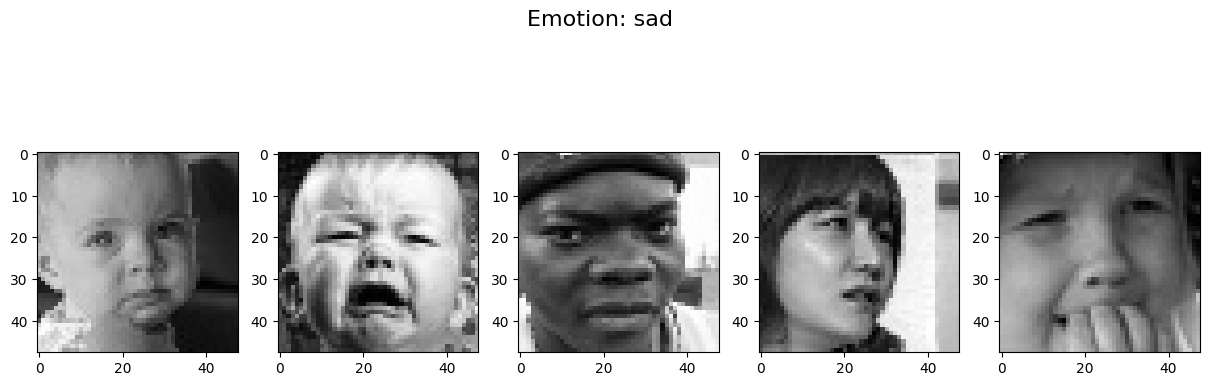

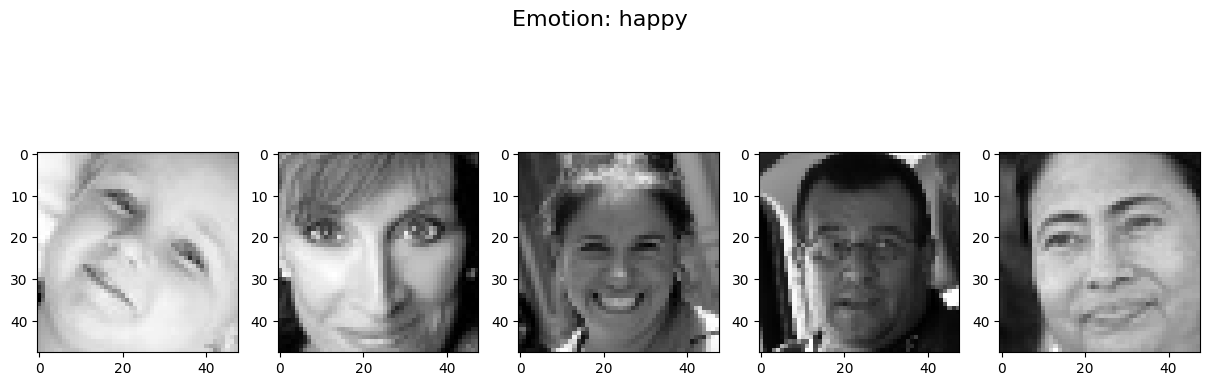

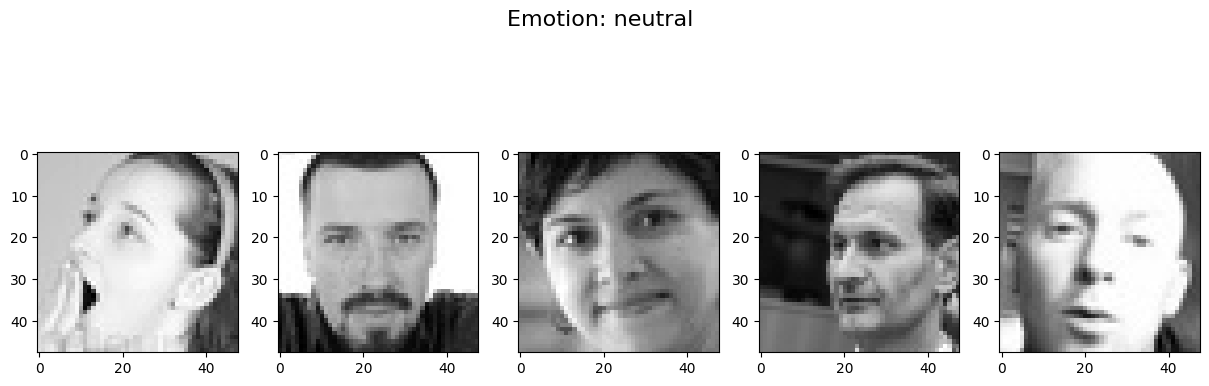

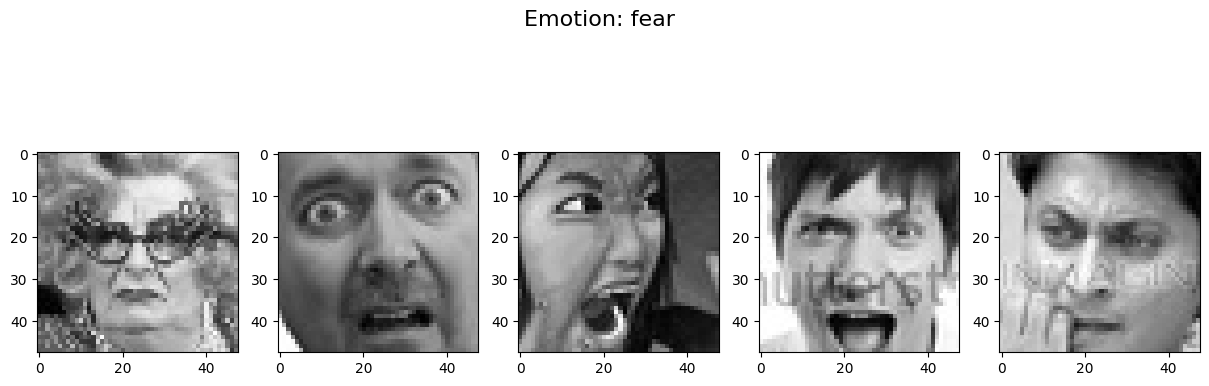

In [ ]:
# Visualize images

def show_images_from_dataset(dataset_dir, num_images=5):
    emotions = os.listdir(dataset_dir)
    for emotion in emotions:
      if emotion[0] != '.': #skip hidden files
          emotion_dir = os.path.join(dataset_dir, emotion)
          img_names = os.listdir(emotion_dir)
          random.shuffle(img_names)

          plt.figure(figsize=(15, 5))
          plt.suptitle(f'Emotion: {emotion}', fontsize=16)

          for i in range(num_images):
              img_path = os.path.join(emotion_dir, img_names[i])
              img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
              if img is not None:
                  plt.subplot(1, num_images, i + 1)
                  plt.imshow(img, cmap='gray')

          plt.show()



show_images_from_dataset(train_dir)

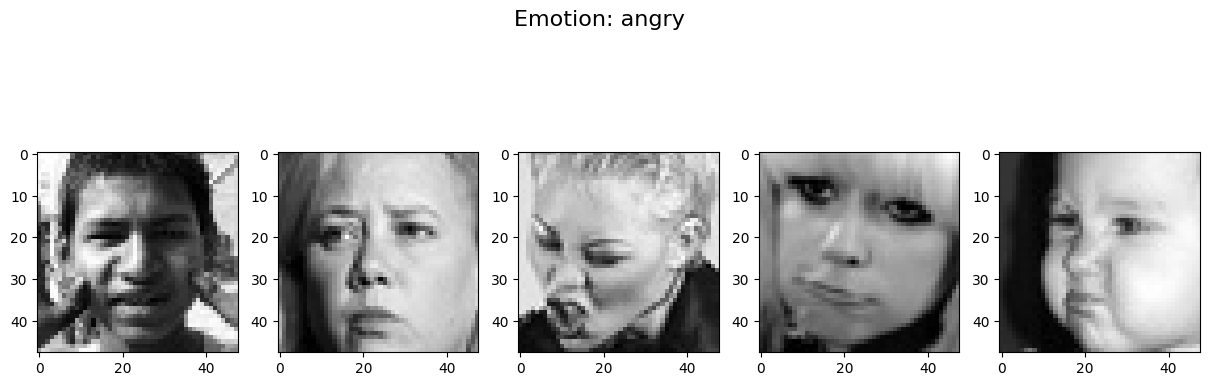

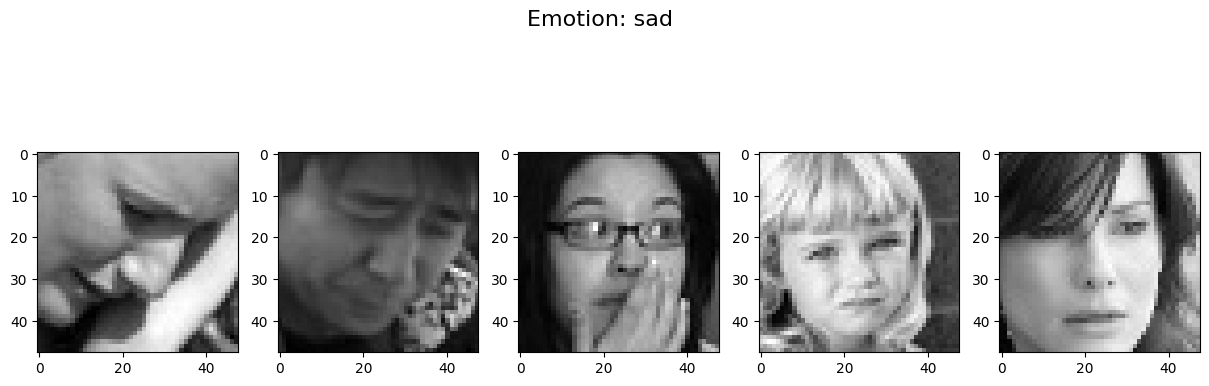

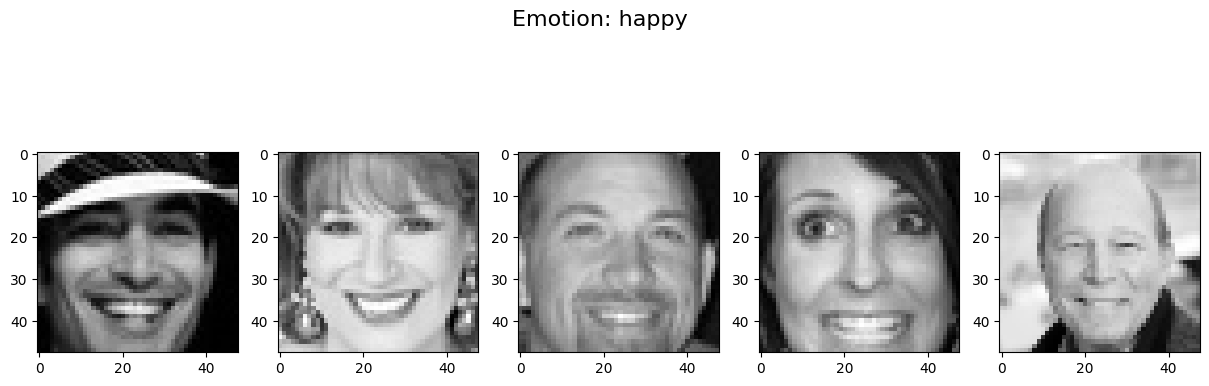

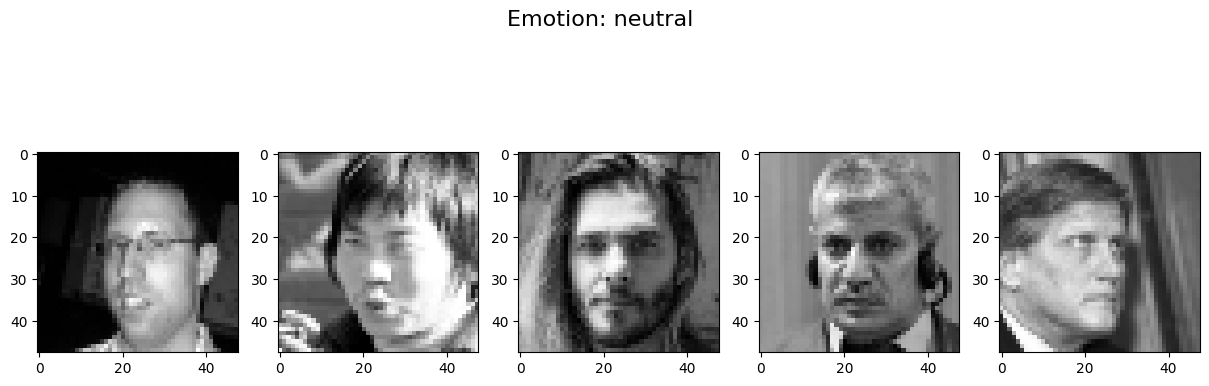

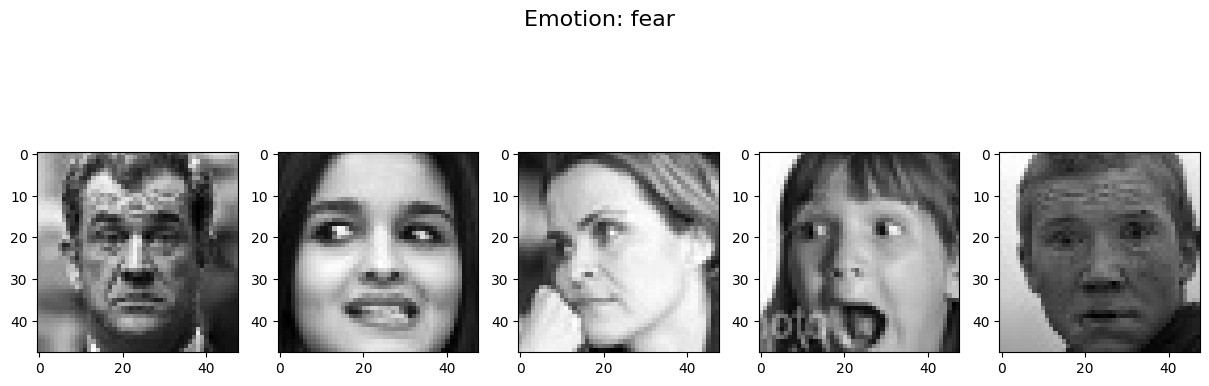

In [ ]:
show_images_from_dataset(test_dir)

# ***8. Preprocessing the Combined Dataset***



*   Shape and batch size are defined
*   Images are normalized. (1 / 255)
*   Data augmentation applied.
*   Train set are shuffled. No need to shuffle test set.

In [ ]:
img_shape = 224
batch_size = 64

train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 40823 images belonging to 5 classes.
Found 10170 images belonging to 5 classes.


# ***9. Default MobileNet Architechture***

*   Pre-trained on ImageNet
*   Input shape fixed to 224x224, RGB (Default)




In [ ]:
# MobileNet is used to speed up the training process and improving the performance
# Pre-trained on ImageNet for feature extraction

MobileNet = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

MobileNet.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [ ]:
layer_count = len(MobileNet.layers)
print(f'The number of layers in MobileNet: {layer_count}')

The number of layers in MobileNet: 86


# ***10. Freeze Layers***
Used a Transfer Learning approach there. Early layers are freezed in order to:
*   Keep the features that ImageNet has learned.
*   Reduce the computational cost.



In [ ]:
# Early layers are freezed in order to retain learned features from imageNet
MobileNet.trainable = True

for layer in MobileNet.layers[:-20]:
    layer.trainable = False

# ***11. Custom CNN with a MobileNet base***



*   Dropped %25 of the layer to prevent overfitting.
*   Batch Normalization applied to prevent Interval Covarince Shift and reduce the learning and validation loss.
*  Flattened to 1D for FC layer.
*  Dense with 64 neurons with activation ReLu.
*  Applied batch normalization again.
*  Dropout increased to 50% this time to further prevent overfitting.
*  Dense with 5 neurons (5 emotions) with softmax is used as a output layer.

In [ ]:
#custom model, applied regularization to prevent overfitting

def Create_MobileNet_Model():

    model = Sequential([
                      MobileNet,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(5,activation='softmax')
                    ])
    return model

In [ ]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()


In [ ]:
MobileNet_Model = Create_MobileNet_Model()

MobileNet_Model.summary()

MobileNet_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1024)        4096      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 64)                3211328   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                2

# ***12. Create Callbacks***



*   Save the model weights with best accuracy
*   ***Early stopping mechanism:*** If validation accuracy doesn't get better within 7 epochs, stop fitting.
* ***Reduce LR:*** If validation loss doesn't get better within 2 epochs, reduce the learning rate by factor 0.2 in order to train a stable and more precise model.



In [ ]:
#Create a checkpoint path
checkpoint_path = "Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Early stopping
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Reduce Learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

# Will be used for fitting
callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

# ***13. Train the Model***



*   Train for 60 epochs.
*   Batch size set to 64.
*   Reduce LR, and Early stepping are set.




In [ ]:
MobileNet_history = MobileNet_Model.fit(train_data ,validation_data = test_data , epochs=60, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
637/637 [==============================] - 445s 685ms/step - loss: 1.2253 - accuracy: 0.5241 - precision: 0.6469 - recall: 0.3727 - val_loss: 1.0019 - val_accuracy: 0.5992 - val_precision: 0.7345 - val_recall: 0.4509 - lr: 0.0010
Epoch 2/60
637/637 [==============================] - 433s 680ms/step - loss: 0.9723 - accuracy: 0.6196 - precision: 0.7546 - recall: 0.4578 - val_loss: 1.0529 - val_accuracy: 0.5941 - val_precision: 0.7155 - val_recall: 0.4717 - lr: 0.0010
Epoch 3/60
637/637 [==============================] - 433s 679ms/step - loss: 0.9114 - accuracy: 0.6473 - precision: 0.7673 - recall: 0.5078 - val_loss: 0.9206 - val_accuracy: 0.6329 - val_precision: 0.7386 - val_recall: 0.5186 - lr: 0.0010
Epoch 4/60
637/637 [==============================] - 436s 684ms/step - loss: 0.8737 - accuracy: 0.6655 - precision: 0.7752 - recall: 0.5333 - val_loss: 0.8495 - val_accuracy: 0.6693 - val_precision: 0.7743 - val_recall: 0.5479 - lr: 0.0010
Epoch 5/60
637/637 [================

# ***14. Evaluate the Model***

In [ ]:
MobileNet_Score = MobileNet_Model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(MobileNet_Score[0]))
print("Test Accuracy: {:.2f}%".format(MobileNet_Score[1] * 100))

159/159 [==============================] - 14s 88ms/step - loss: 0.7858 - accuracy: 0.7107 - precision: 0.7639 - recall: 0.6527
Test Loss:     0.78581
Test Accuracy: 71.07%


# ***15. Plot the Curves***



*   Training and Validation Loss curves
*   Accuracy curves
*   Precision and Recall curves


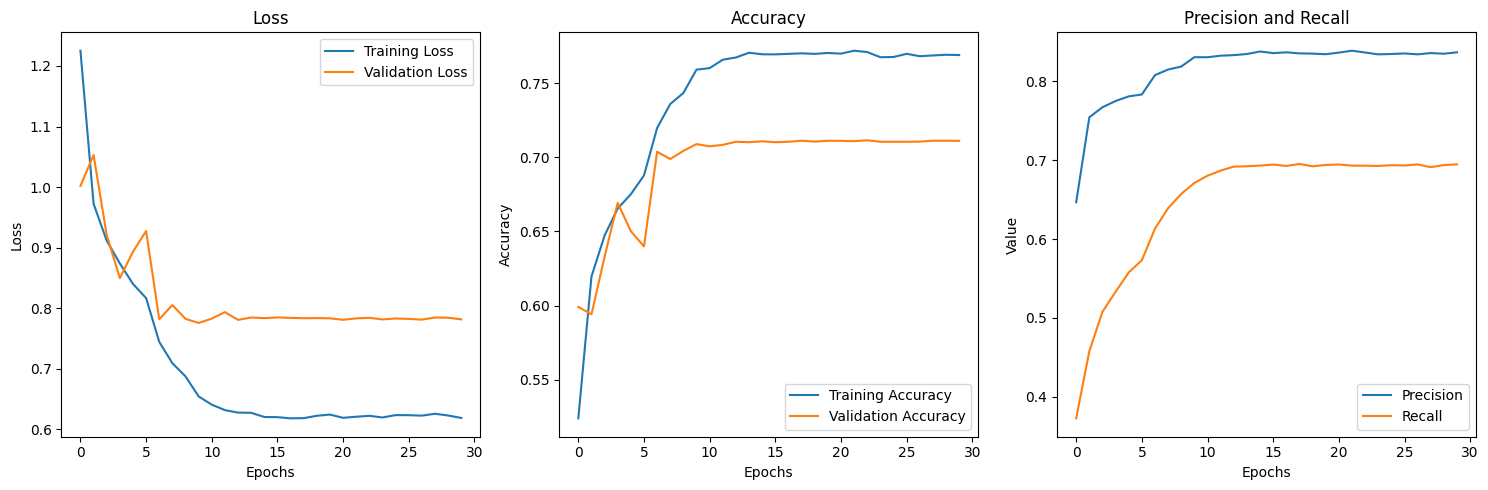

In [ ]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    precision = history.history["precision"]
    recall = history.history["recall"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot precision and recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, precision, label="Precision")
    plt.plot(epochs, recall, label="Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_curves function after training
plot_curves(MobileNet_history)

In [ ]:
MobileNet_Predictions = MobileNet_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
MobileNet_Predictions = np.argmax(MobileNet_Predictions, axis=1)

159/159 [==============================] - 15s 89ms/step


# ***16. Final Metrics***

In [ ]:
history = MobileNet_history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 76.89%
Final Precision       : 83.70%
Final Recall          : 69.49%
Final Validation Loss : 0.7812
Final F1 Score        : 0.759


Text(0.5, 1.0, 'MobileNet Confusion Matrix')

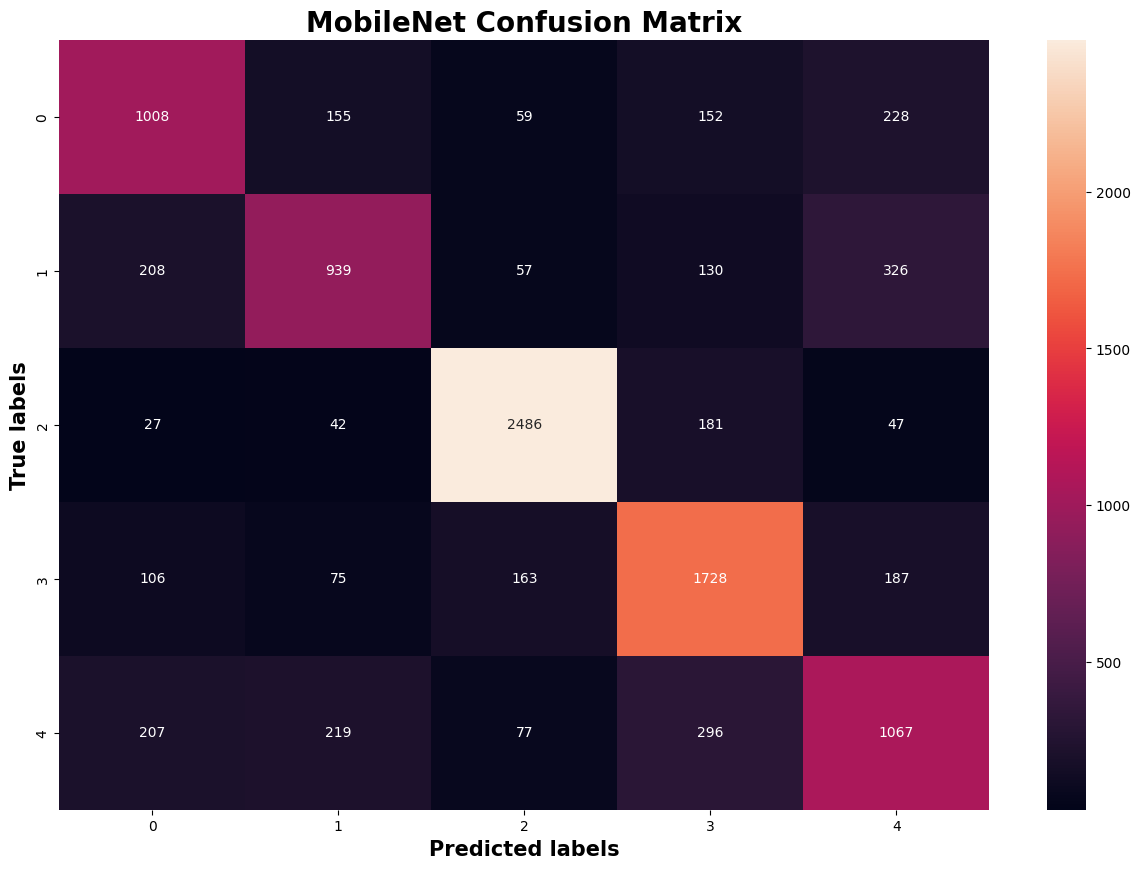

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, MobileNet_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('MobileNet Confusion Matrix', fontsize=20, fontweight='bold')

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 10170 images belonging to 5 classes.


# ***17. Visualize Predictions***

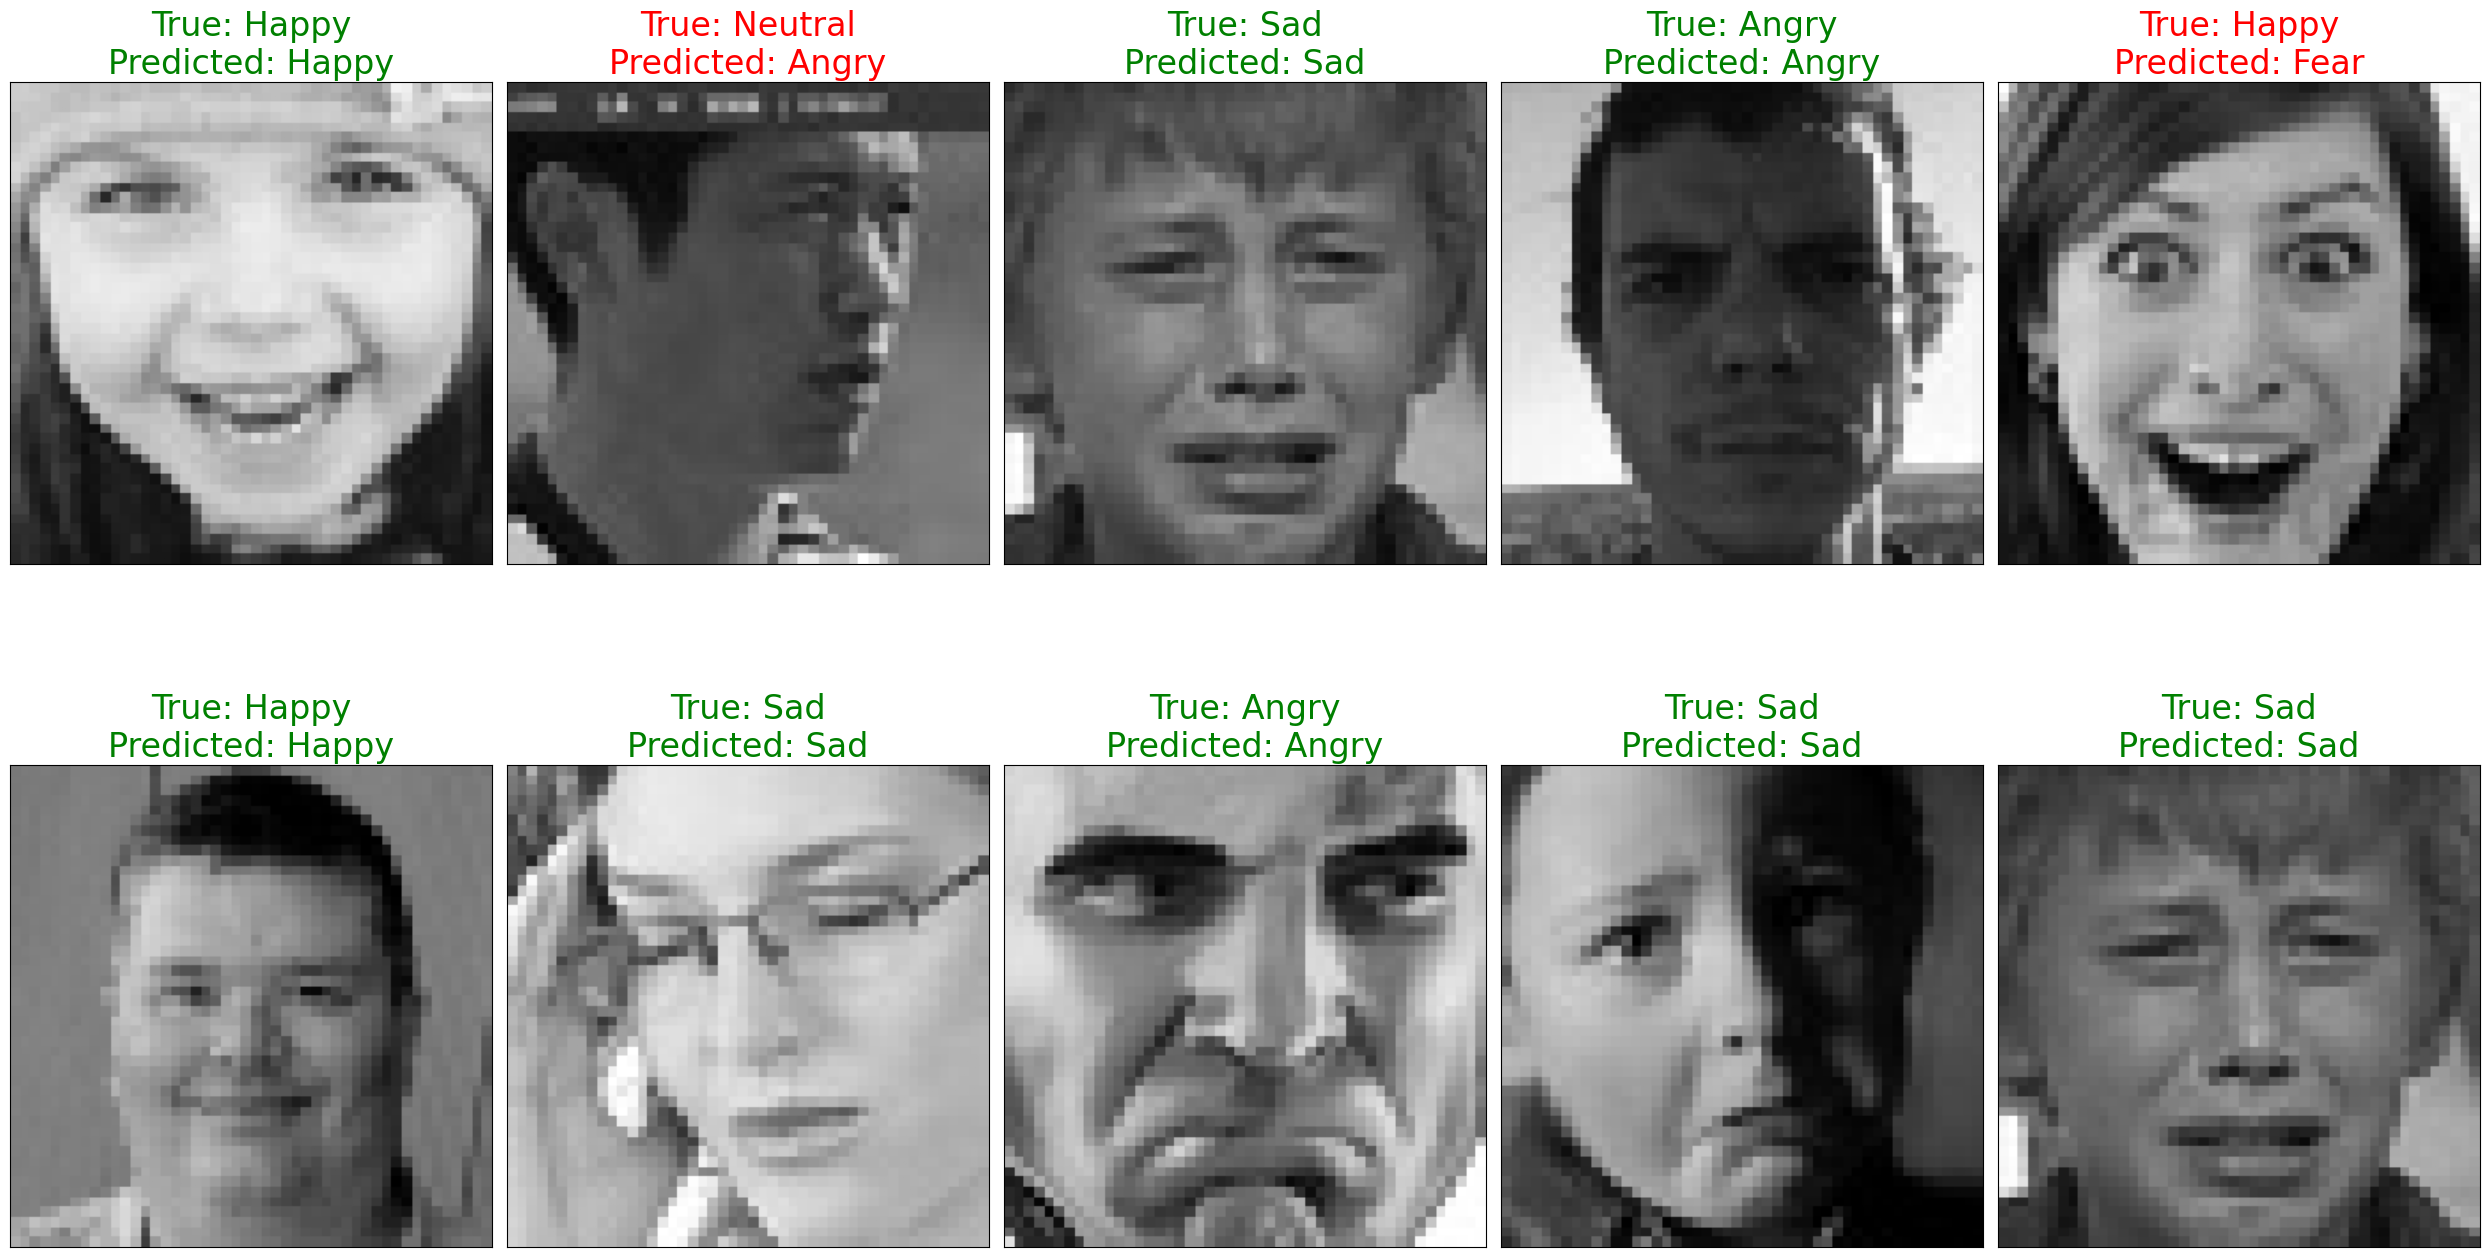

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

class_indices = test_data.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(MobileNet_Model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))

    ax.imshow(Random_Img_resized)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=24)

plt.tight_layout()
plt.show()

# ***18. Load Haar Cascade for Face Detection***

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2024-06-18 18:39:30--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.01s   

2024-06-18 18:39:30 (90.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



# ***18. Predict different images from local***

In [ ]:
import cv2
import matplotlib.pyplot as plt

def load_and_prep_image(filename, img_shape = 48):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)

    for x,y,w,h in faces:

        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]

        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)

        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [ ]:
def pred_and_plot(filename, class_names, size):

    Random_Img = load_and_prep_image(filename, size)

    Model_Prediction = np.argmax(MobileNet_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    pred_class = class_names[Model_Prediction]
    print("Sentiment Identified as: ", pred_class)

    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()
    print()


Sentiment Identified as:  Sad


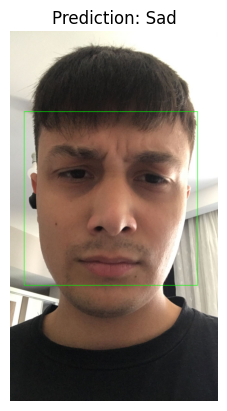

In [ ]:
pred_and_plot("/content/6fe17b3e-3bca-4e7b-a292-c333b1c22db5.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Fear


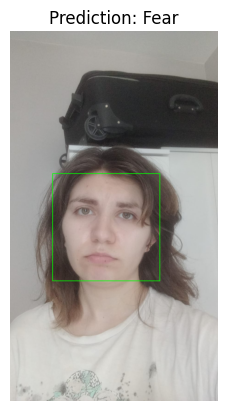

In [ ]:
pred_and_plot("/content/e3a43bb3-695c-46b9-8d16-c7c29574fba1.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Fear


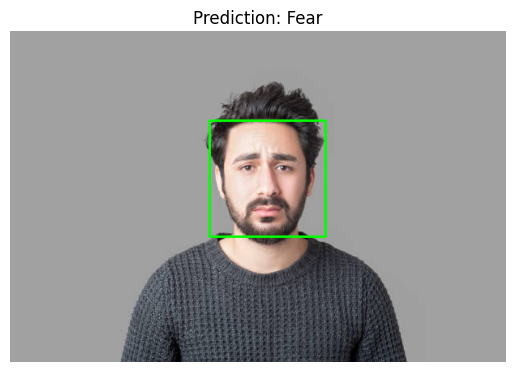

In [ ]:
pred_and_plot("/content/istockphoto-1148040425-612x612.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Fear


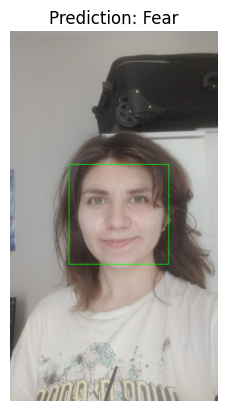

In [ ]:
pred_and_plot("/content/bd00e05b-a802-4d72-b1f7-f49dd82ff189.jpg", Emotion_Classes, 224)

In [ ]:
pred_and_plot("/content/bd00e05b-a802-4d72-b1f7-f49dd82ff189.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Angry


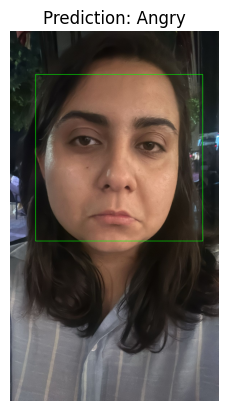

In [ ]:
pred_and_plot("/content/a0b2964a-d23e-4277-9c49-c76ec81d8e70.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Happy


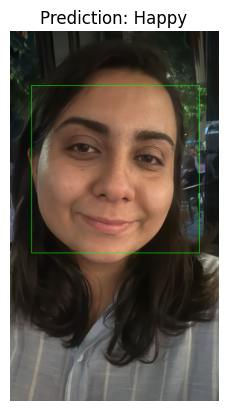

In [ ]:
pred_and_plot("/content/c97630b4-5e6b-451a-b415-2a0962d4108f.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Angry


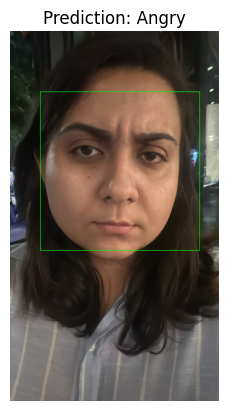

In [ ]:
pred_and_plot("/content/87304e47-d5cc-48a8-ae75-084f28516afd.jpg", Emotion_Classes, 224)

No Faces Detected
No Faces Detected
Sentiment Identified as:  Fear


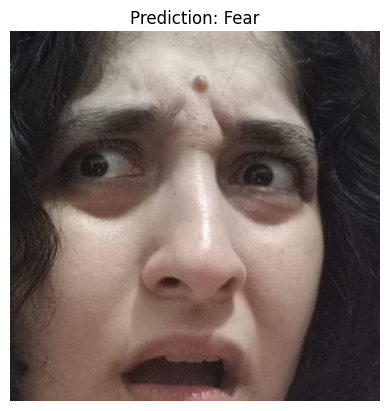

In [ ]:
pred_and_plot("/content/3f12e5d8-14d8-4e70-8dfe-d4fdd6248e97.jpg", Emotion_Classes, 224)

No Faces Detected
Sentiment Identified as:  Fear


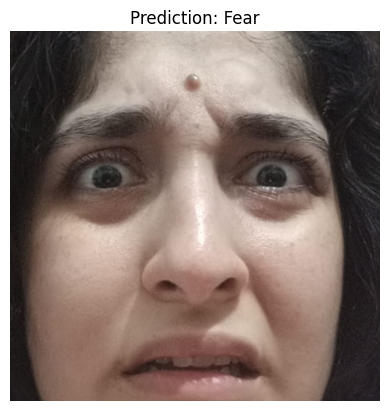

In [ ]:
pred_and_plot("/content/64a49edd-f98c-4239-8d2d-4f9c68bd83ea.jpg", Emotion_Classes, 224)

No Faces Detected
Sentiment Identified as:  Sad


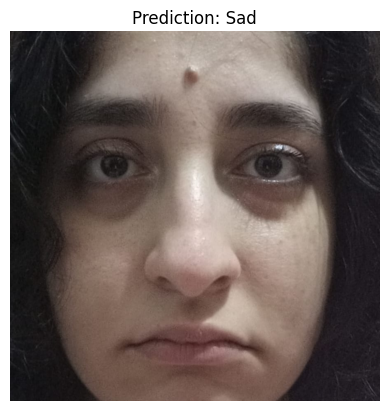

In [ ]:
pred_and_plot("/content/40963113-97c8-4cfa-a484-f33775aa4414.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Happy


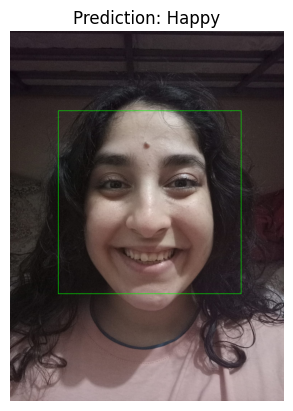

In [ ]:
pred_and_plot("/content/95575374-9d73-403f-8e88-cefe62bdeb71.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Fear


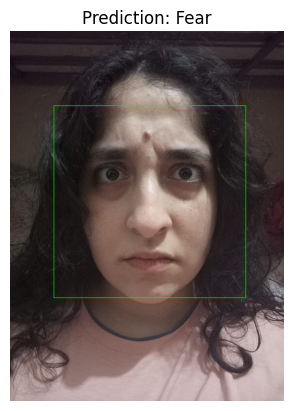

In [ ]:
pred_and_plot("/content/a3f0f586-6d1c-4c63-99cd-97c1f0fa6bfa.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Fear


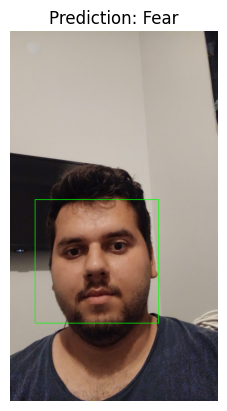

In [ ]:
pred_and_plot("/content/8b7490d6-0958-4c3c-ad71-c052dd4da53e.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Angry


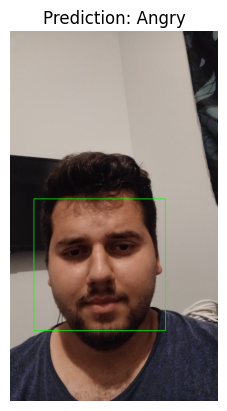

In [ ]:
pred_and_plot("/content/13d205e8-6e1f-4791-9cda-4d433a0d268f.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Angry


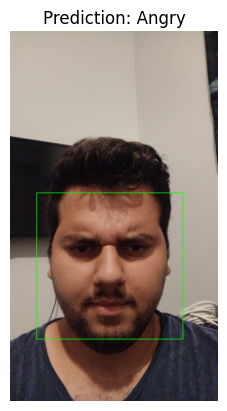

In [ ]:
pred_and_plot("/content/b5b32ac3-2dfd-4fa7-9320-da9c493027a4.jpg", Emotion_Classes, 224)

In [ ]:
MobileNet_Model.save("mobile-model.keras")

Sentiment Identified as:  Happy


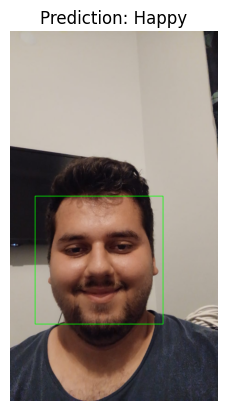

In [ ]:
pred_and_plot("/content/dfeb0cbd-b4a1-4417-8447-c610e5ac58c5.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Sad


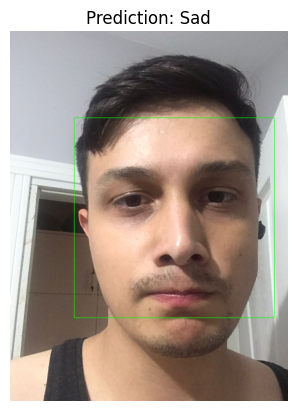

In [ ]:
pred_and_plot("/content/06daa764-afc1-4e7b-949c-967d4bc11b95.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Neutral


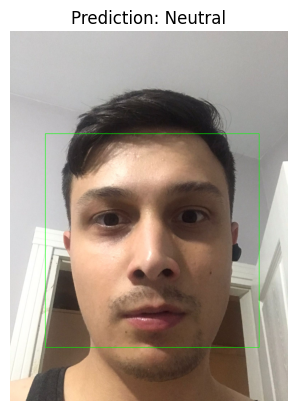

In [ ]:
pred_and_plot("/content/fbdde8e2-6702-496b-b360-64cfcda86121.jpg", Emotion_Classes, 224)

Sentiment Identified as:  Angry


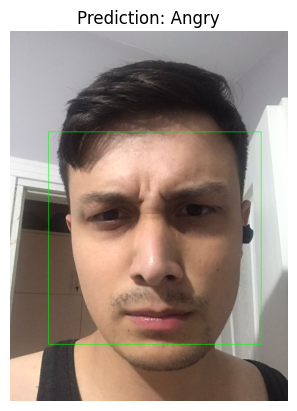

In [ ]:
pred_and_plot("/content/2762cb3a-002c-42ac-9f7e-e8738b4d2b81.jpg", Emotion_Classes, 224)

In [ ]:

model = load_model('mobile-model.keras')

NameError: name 'load_model' is not defined